In [102]:
#importing necessary libraries
import glob
import nltk
import os
import pandas as pd
import numpy as np
import json
import gensim
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


#gensim libraries
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags, remove_stopwords, STOPWORDS
from sklearn.metrics import f1_score
from gensim.models import Word2Vec

#sk-learn libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

#confg libraries
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [21]:
df = pd.read_excel("abstract_excel.xlsx") # reading excel file/csv file.

In [22]:
df.head(4)

,Title,Abstract,Filename
0,One-stop shops for residential building energy renovation in the EU,"This report is the second part of a Europe-wide survey and assessment of one-stop shops (OSS) for energy renovation of buildings. Based on the case studies of 63 OSS in the EU, we find that the approach has a potential to cover 5-6% of the renovation volume of 35 million buildings in 2030 set out by the Renovation Wave Strategy1,2 at low social costs, integrating private investments with client-friendly methods. The current level of activity of the European OSS market is estimated to be around 100 000 projects per year.\nThe OSS can bridge the gap between a fragmented residential building sector, with a large heterogeneous set of households, and the construction supply side. They can help increase the actual renovation rate by supporting potential clients through the various steps of the decision-making process. Their success lies in part with their locally embedded focus, engagement with interested but not yet committed energy users/asset owners and ability to form strong relationships with clients. They can support the renovation journey from start to finish and can facilitate access to financing, occasionally offering better rates. While our analysis identifies several structural, legislative, financial, and information measures with a positive impact on OSS-enabled renovation projects, it is possible to enhance their contribution by reviewing specific policies that support or hinder their success. Although not typical of OSS in general, but with proper incentives, they can improve the average renovation depth in terms of energy performance level by adopting a holistic approach and, at the same time, they can reach out to vulnerable populations, such as tenants of social houses, thus contributing to the alleviation of energy poverty. Finally, OSS can contribute to the enhancement of communities and neighbourhoods. They help current tenants to improve their living conditions and thus stay in the area.",One-stop shops for residential building.pdf
1,HOW BUILDING INSULATION CAN REDUCE FOSSIL FUEL IMPORTS AND BOOST EU ENERGY SECURITY,"This paper investigates how improving the energy performance of the building envelope in selected EU Member States would lower fossil fuel consumption, increase energy security and enable the growth of renewable heat. The study shows how improving insulation can reduce energy demand and drastically cut Russian oil and gas imports for heating in buildings. Investing in building renovation can reduce the use of fossil fuels for heating in buildings, reaching 44% in gas savings, save 45% of final energy demand and substantially contribute to securing the EU’s energy needs.",HOW BUILDING INSULATION CAN REDUCE.pdf
2,Impact assessment of the MEPS under discussion in the context of the EPBD,"Minimum Energy Performance Standards (MEPS) are under discussion in the frame of the revision of the Energy Performance of Buildings Directive (EPBD) as a tool to trigger renovation of buildings in the European Union and reduce GHG emissions. To inform this discussion, Climact and BPIE modelled the impacts of MEPS schemes on the European building stock. This allows comparing the ambition of MEPS as originally proposed by the European Commission with two other scenarios: the REPowerEU plan and a scenario aligned with the EU climate and energy consumption reduction targets set by Fitfor552. The modelling was done in June 2022 and mainly accounts for the proposals from the EU Commission, REPowerEU and the EP rapporteur for the EPBD revision, Ciáran Cuffe.",Impact assessment of the MEPS.pdf
3,Recommendations for industrialised renovation,"Action and innovation are needed to achieve the EU climate goal of full, societywide\ndecarbonisation by 2050. The EU is committed to a 55% reduction of\ngreenhouse-gas emissions by 2030.1 The 2022 REPowerEU plan puts increased\nemphasis on decarbonisation, notably through reducing energy dema

In [23]:
## creating a list for storing the abstract and filename column 
abstract_list = df['Abstract']
filename_list = df["Filename"]

In [24]:
abstract_list[0]

'This report is the second part of a Europe-wide survey and assessment of one-stop shops (OSS) for energy renovation of buildings. Based on the case studies of 63 OSS in the EU, we find that the approach has a potential to cover 5-6% of the renovation volume of 35 million buildings in 2030 set out by the Renovation Wave Strategy1,2 at low social costs, integrating private investments with client-friendly methods. The current level of activity of the European OSS market is estimated to be around 100 000 projects per year.\nThe OSS can bridge the gap between a fragmented residential building sector, with a large heterogeneous set of households, and the construction supply side. They can help increase the actual renovation rate by supporting potential clients through the various steps of the decision-making process. Their success lies in part with their locally embedded focus, engagement with interested but not yet committed energy users/asset owners and ability to form strong relationshi

#### Preprocessing of the text  

1. remove punctuation and stopwords.
2. implement lemmatization
3. unnecessary white space chr and space. +++

In [25]:
#stop word removal 
import spacy
nlp=spacy.load('en_core_web_sm')
import string
from spacy.lang.en.stop_words import STOP_WORDS

In [26]:
punctuations = string.punctuation
stop_words = list(STOP_WORDS)

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier'
]

#add domain stop words

for w in custom_stop_words:
    if w not in stop_words:
        stop_words.append(w)

In [27]:
def tokenize_corpus(abstract_text):
    mytokens = nlp(abstract_text)
    mytokens = [ word.lemma_.strip() if word.lemma_ != "-PRON-" else word for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [28]:
df["processed_text"] = df["Abstract"].apply(tokenize_corpus)

In [29]:
df.head(3)

,Title,Abstract,Filename,processed_text
0,One-stop shops for residential building energy renovation in the EU,"This report is the second part of a Europe-wide survey and assessment of one-stop shops (OSS) for energy renovation of buildings. Based on the case studies of 63 OSS in the EU, we find that the approach has a potential to cover 5-6% of the renovation volume of 35 million buildings in 2030 set out by the Renovation Wave Strategy1,2 at low social costs, integrating private investments with client-friendly methods. The current level of activity of the European OSS market is estimated to be around 100 000 projects per year.\nThe OSS can bridge the gap between a fragmented residential building sector, with a large heterogeneous set of households, and the construction supply side. They can help increase the actual renovation rate by supporting potential clients through the various steps of the decision-making process. Their success lies in part with their locally embedded focus, engagement with interested but not yet committed energy users/asset owners and ability to form strong relationships with clients. They can support the renovation journey from start to finish and can facilitate access to financing, occasionally offering better rates. While our analysis identifies several structural, legislative, financial, and information measures with a positive impact on OSS-enabled renovation projects, it is possible to enhance their contribution by reviewing specific policies that support or hinder their success. Although not typical of OSS in general, but with proper incentives, they can improve the average renovation depth in terms of energy performance level by adopting a holistic approach and, at the same time, they can reach out to vulnerable populations, such as tenants of social houses, thus contributing to the alleviation of energy poverty. Finally, OSS can contribute to the enhancement of communities and neighbourhoods. They help current tenants to improve their living conditions and thus stay in the area.",One-stop shops for residential building.pdf,"report second Europe wide survey assessment stop shop OSS energy renovation building base case study 63 OSS EU find approach potential cover 5 6 renovation volume 35 million building 2030 set Renovation Wave Strategy1,2 low social cost integrate private investment client friendly method current level activity European OSS market estimate 100 000 project year OSS bridge gap fragmented residential building sector large heterogeneous set household construction supply help increase actual renovation rate support potential client step decision process success lie locally embed focus engagement interested commit energy user asset owner ability form strong relationship client support renovation journey start finish facilitate access financing occasionally offer rate analysis identify structural legislative financial information measure positive impact oss enable renovation project possible enhance contribution review specific policy support hinder success typical OSS general proper incentive improve average renovation depth term energy performance level adopt holistic approach time reach vulnerable population tenant social house contribute alleviation energy poverty finally OSS contribute enhancement community neighbourhood help current tenant improve living condition stay area"
1,HOW BUILDING INSULATION CAN REDUCE FOSSIL FUEL IMPORTS AND BOOST EU ENERGY SECURITY,"This paper investigates how improving the energy performance of the building envelope in selected EU Member States would lower fossil fuel consumption, increase energy security and enable the growth of renewable heat. The study shows how improving insulation can reduce energy demand and drastically cut Russian oil and gas imports for heating in buildings. Investing in building renovation can reduce the use of fossil fuels for heating in buildings, reaching 44% in gas savings, save 45% of final energy demand and substanti

#### Applying Word-Embedding

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    print(vectorizer.get_feature_names_out())
    return X

In [47]:
pro_text = df['processed_text'].values
max_features = 2**8
X = vectorize(pro_text, max_features)

['2050' 'account' 'achieve' 'action' 'address' 'aim' 'air' 'allow'
 'alternative' 'analyse' 'analysis' 'annual' 'application' 'apply'
 'approach' 'area' 'article' 'assess' 'assessment' 'average' 'barrier'
 'base' 'benefit' 'build' 'building' 'carbon' 'case' 'challenge' 'change'
 'circular' 'city' 'climate' 'co2' 'combine' 'comfort' 'compare'
 'component' 'comprehensive' 'concept' 'condition' 'consider'
 'construction' 'consumption' 'context' 'contribute' 'control' 'cool'
 'cost' 'country' 'current' 'cycle' 'datum' 'decision' 'define' 'demand'
 'design' 'develop' 'development' 'different' 'directive' 'district'
 'dynamic' 'economic' 'economy' 'effect' 'effective' 'efficiency'
 'efficient' 'electricity' 'element' 'embody' 'emission' 'enable' 'end'
 'energy' 'envelope' 'environment' 'environmental' 'eu' 'europe'
 'european' 'evaluate' 'evaluation' 'exist' 'factor' 'far' 'find' 'focus'
 'framework' 'future' 'gap' 'gas' 'global' 'goal' 'good' 'green'
 'greenhouse' 'grid' 'heat' 'heating' 'h

#### Application of clustering algorithm

In [94]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k values
distortions = []
K = range(2, 15)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X)
    k_means.fit(X)
    distortions.append(sum(np.min(cdist(X.toarray(), k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [11]:
## perform elbow method
## decide on number of cluster based on elbow method 
## try to visulaize in the graph 
## vectorize the data 
## perform topic modeling
## append the keywords to df

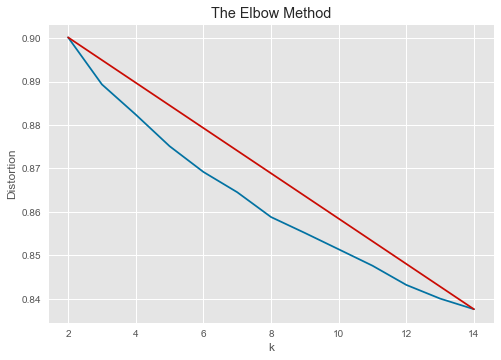

In [95]:
plt.style.use('ggplot')

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

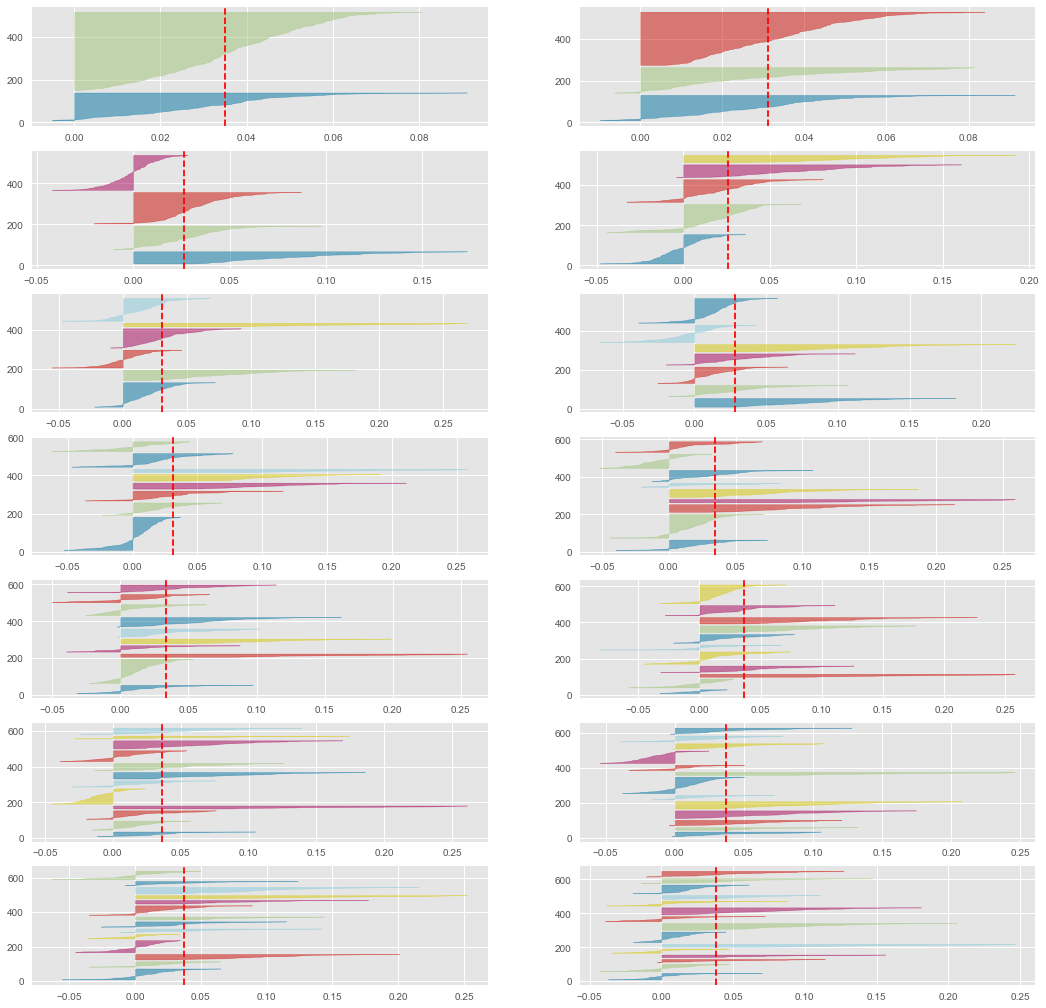

In [84]:
# from sklearn import datasets
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# from yellowbrick.cluster import SilhouetteVisualizer

# fig, ax = plt.subplots(7, 2, figsize=(18,18))
# for i in [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15]:

#     '''
#     Create KMeans instances for different number of clusters
#     '''
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
#     q, mod = divmod(i, 2)
#     '''
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
#     '''
#     visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit(X) 

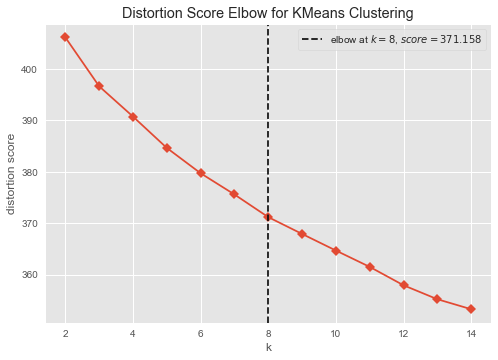

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
# from sklearn import datasets
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer



# # Instantiate the clustering model and visualizer
# km = KMeans(random_state=42)
# visualizer = KElbowVisualizer(km, k=(2,15), timings= False)
 
# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

After performing "elbow method" twice and "silhouette-score" , we come to the conclusion that k=9 is the optimal value for k-means algo.

In [96]:
k = 9 # as decided 
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
df['cluster_no'] = y_pred

500

In [107]:
df.head(2)

,Title,Abstract,Filename,processed_text,cluster_no
0,One-stop shops for residential building energy renovation in the EU,"This report is the second part of a Europe-wide survey and assessment of one-stop shops (OSS) for energy renovation of buildings. Based on the case studies of 63 OSS in the EU, we find that the approach has a potential to cover 5-6% of the renovation volume of 35 million buildings in 2030 set out by the Renovation Wave Strategy1,2 at low social costs, integrating private investments with client-friendly methods. The current level of activity of the European OSS market is estimated to be around 100 000 projects per year.\nThe OSS can bridge the gap between a fragmented residential building sector, with a large heterogeneous set of households, and the construction supply side. They can help increase the actual renovation rate by supporting potential clients through the various steps of the decision-making process. Their success lies in part with their locally embedded focus, engagement with interested but not yet committed energy users/asset owners and ability to form strong relationships with clients. They can support the renovation journey from start to finish and can facilitate access to financing, occasionally offering better rates. While our analysis identifies several structural, legislative, financial, and information measures with a positive impact on OSS-enabled renovation projects, it is possible to enhance their contribution by reviewing specific policies that support or hinder their success. Although not typical of OSS in general, but with proper incentives, they can improve the average renovation depth in terms of energy performance level by adopting a holistic approach and, at the same time, they can reach out to vulnerable populations, such as tenants of social houses, thus contributing to the alleviation of energy poverty. Finally, OSS can contribute to the enhancement of communities and neighbourhoods. They help current tenants to improve their living conditions and thus stay in the area.",One-stop shops for residential building.pdf,"report second Europe wide survey assessment stop shop OSS energy renovation building base case study 63 OSS EU find approach potential cover 5 6 renovation volume 35 million building 2030 set Renovation Wave Strategy1,2 low social cost integrate private investment client friendly method current level activity European OSS market estimate 100 000 project year OSS bridge gap fragmented residential building sector large heterogeneous set household construction supply help increase actual renovation rate support potential client step decision process success lie locally embed focus engagement interested commit energy user asset owner ability form strong relationship client support renovation journey start finish facilitate access financing occasionally offer rate analysis identify structural legislative financial information measure positive impact oss enable renovation project possible enhance contribution review specific policy support hinder success typical OSS general proper incentive improve average renovation depth term energy performance level adopt holistic approach time reach vulnerable population tenant social house contribute alleviation energy poverty finally OSS contribute enhancement community neighbourhood help current tenant improve living condition stay area",4
1,HOW BUILDING INSULATION CAN REDUCE FOSSIL FUEL IMPORTS AND BOOST EU ENERGY SECURITY,"This paper investigates how improving the energy performance of the building envelope in selected EU Member States would lower fossil fuel consumption, increase energy security and enable the growth of renewable heat. The study shows how improving insulation can reduce energy demand and drastically cut Russian oil and gas imports for heating in buildings. Investing in building renovation can reduce the use of fossil fuels for heating in buildings, reaching 44% in gas savings, save 45% of final energy demand 

In [103]:
tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.343423
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.545181
[t-SNE] KL divergence after 1000 iterations: 1.181660


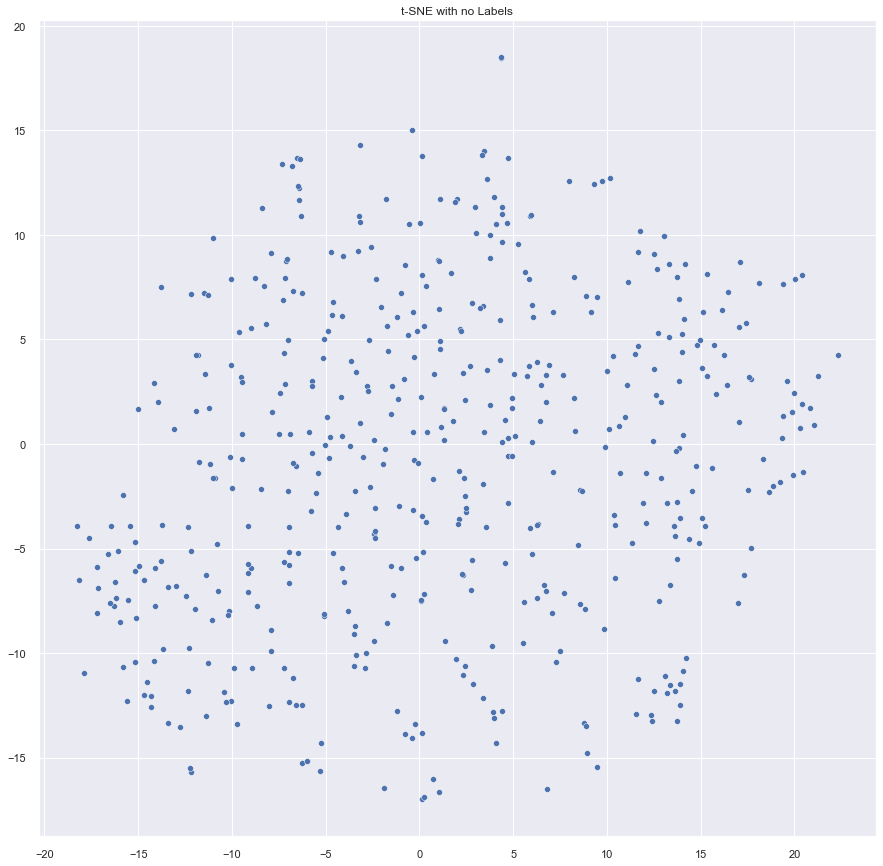

In [112]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_no_labels.png")
plt.show()

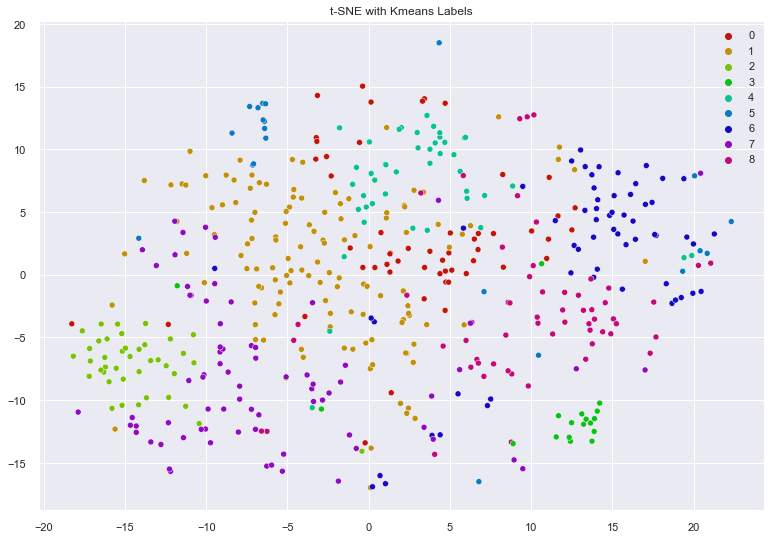

In [113]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(9, l=0.4, s=0.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()